Pytorch reference, for training vision functions, on a simpler dataset MINST.

In [ ]:
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from datetime import datetime
import os
from pathlib import Path

TODO, ideas to add
earlystopping, learning rate finder, most confused, captum model interpretation, simpler loss plot

Custom packages that need to be installed separately.
 - torchinfo, shows the structure of neural network
 - torchmetrics, implements certain metrics out of the box


In [ ]:
!pip install torchinfo
!pip install torchmetrics

from torchinfo import summary
from torchmetrics import Accuracy

finish this tutorial:

https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37


**Comparison between Torch and FastAi concepts**

PyTorch's Dataset and DataLoader are indeed similar  in concept to fastai's DataBlock and DataLoader,
but there are some key differences in how they are used and what they provide.

In essence, fastai's DataBlock and DataLoader can be seen as a more opinionated and user-friendly wrapper around PyTorch's Dataset and DataLoader, providing a streamlined way to prepare data for deep learning models.


**FastAI DataBlock vs PyTorch Dataset:**


- Pytorch Dataset:	This is an abstract class that represents a dataset. You need to create a custom class that inherits from Dataset and implements the __len__ and __getitem__ methods.	__len__ should return the size of the dataset, and __getitem__ should return a sample (data and label) given an index.

- Fastai  DataBlock:	This is a high-level API that simplifies the process of creating datasets and dataloaders. It allows you to define the structure of your data, how to get the items, how to split the data into training and validation sets, how to apply transformations, and how to create the dataloaders. It encapsulates many steps that you would typically do manually with PyTorch Dataset and DataLoader.

Both represent the dataset, one is more opiniated than the other:

- Level of Abstraction: Fastai's DataBlock provides a much higher level of abstraction compared to PyTorch's Dataset.	With DataBlock, you define the data pipeline declaratively, while with PyTorch Dataset, you implement the data loading logic imperatively.

- Flexibility: PyTorch's Dataset is more flexible if you need to implement very custom data loading logic that is not easily expressed with DataBlock.

- Ease of Use: Fastai's DataBlock is generally easier to use for common deep learning tasks, as it handles many of the details for you.


**FastAI DataLoader vs PyTorch DataLoader:**

In both libraries this class wraps a Dataset/Datablock and provides an iterable over the it. It handles batching, shuffling, and parallel loading of data.

FastAI DataLoader is built on top of PyTorch's DataLoader and adds more features, such as transformations applied on the GPU and progress bars.

PyTorch   .view():

In PyTorch, when you use .view() to reshape a tensor, the parameter -1 is a placeholder that tells PyTorch to automatically infer the size of that dimension.
.view(-1) means that tensor will be reshaped to single dimension tensor only one dimension can be infered, be -1:

```
flattened_image = image.view(-1)
```


.view() is generally memory-efficient because it avoids data copies,
but be mindful of memory contiguity for optimal performance.




In [ ]:
def calculate_mean_and_std_formula(dataset):
  total_pixels_count = 0
  sum_pixels = 0

  # _ is the label in data
  for image, _ in dataset:
      flattened_image = image.view(-1)
      sum_pixels += flattened_image.sum()
      total_pixels_count += flattened_image.numel()
  mean = sum_pixels / total_pixels_count

  sum_sq_diff = 0
  for image, _ in dataset:
      sq_diff = (image.view(-1) - mean) ** 2
      sum_sq_diff += sq_diff.sum()

  variance = sum_sq_diff / total_pixels_count
  std_dev = torch.sqrt(variance)
  return {'mean': mean.item(), 'std_dev': std_dev.item()}

In PyTorch you can get a single Python number from a PyTorch tensor containing a single value by using the .item() method.

torch.stack:  concatenates a sequence of tensors along a new dimension.




In [ ]:
def calculate_mean_and_std(dataset):
  imgs = torch.stack([img for img, _ in dataset], dim=0)
  return {'mean': imgs.mean().item(), 'std_dev': imgs.std().item()}

In [ ]:
calculate_mean_and_std(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.ToTensor()))

{'mean': 0.13066047430038452, 'std_dev': 0.30810782313346863}

In [ ]:
calculate_mean_and_std_formula(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.ToTensor()))

{'mean': 0.13066048920154572, 'std_dev': 0.308107852935791}

Training of the dataset:

In [ ]:
train_dataset =  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                             ])),

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset)

**Description of PyTorch nn classes:**

**nn.Module**

is the base class for all neural network modules. It provides a framework for building and managing neural network layers and models.

You need to implement all the layers in costructor:

`def __init__(self):`

the forward method, that implements the forward pass in neural network.

`def forward(self, x):`



**nn.Sequential**

is a container module that stacks other modules (like layers such as convolutional layers, activation functions, pooling layers, etc.) in a specific sequential order.
It ensures that the input is passed through each module in the sequence, and the output of one module becomes the input for the next




LeNet-5 neural network:


Padding of 2 is added on first layer, since input images here have size 28x28.
From here https://github.com/torch/tutorials/issues/48:
The MNIST dataset contains vectorized images of 28X28. Therefore we define a new function to reshape each batch of MNIST images to 28X28 and then resize to 32X32. The reason of resizing to 32X32 is to make it a power of two and therefore we can easily use the stride of 2 for downsampling and upsampling.




Max pooling is used instead of average pooling, because
MNIST digits dataset using CNN, max pooling is used because the background in these images is made black with white foreground.

[reference article](https://medium.com/@bdhuma/which-pooling-method-is-better-maxpooling-vs-minpooling-vs-average-pooling-95fb03f45a9
)

architecture:

https://medium.com/@siddheshb008/lenet-5-architecture-explained-3b559cb2d52b

https://www.geeksforgeeks.org/computer-vision/lenet-5-architecture/



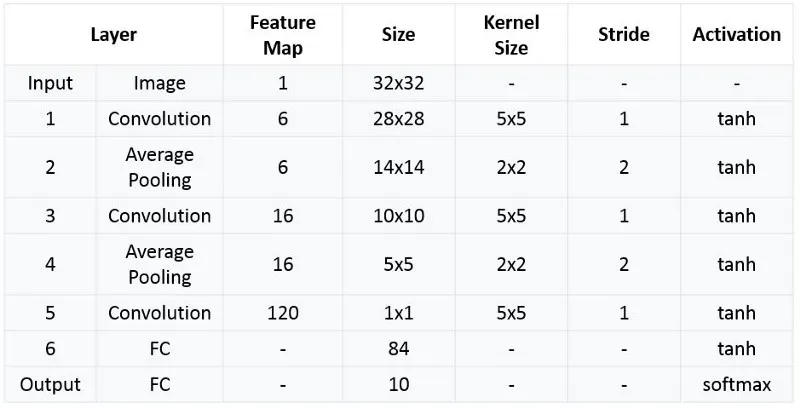

Pooling methods in PyTorch:

https://medium.com/@benjybo7/7-pytorch-pool-methods-you-should-be-using-495eb00325d6


In [ ]:
class LeNet5Variant(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14

            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 5*5

        )
        self.classifier = nn.Sequential(
            # transforms extracted features into single tensor
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))


Why are same layers called feature and some classifier:

- Feature layers are layers that extract features:

   Convolutional and Pooling Layers: These layers process the input image, extracting spatial hierarchies of features. The output of the last pooling layer is usually a flattened tensor (a one-dimensional array) representing the features.


-  Classifier layers, are layers that then classifiy this features:
   
   Fully Connected Layers receive flattened tensor as input from feature extractor, that is then passed to one or more fully connected layers.   In these layers, every neuron is connected to every neuron in the previous layer, just like in a standard neural network. These layers learn non-linear combinations of the extracted features.

Essentially, the convolutional and pooling layers act as feature extractors, and the fully connected layers act as classifiers that use those extracted features to make a decision.


Model summary output, with this you can also test if structure of network is correct. If operations don't match error will be thrown


In [ ]:
model_lenet5 = LeNet5Variant()
summary(model=model_lenet5, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5Variant (LeNet5Variant)            [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 1, 28, 28]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─Tanh (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─MaxPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Tanh (4)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─MaxPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classifi

Dataset MNIST doesn't come with validation part out of the box.
Here a split is performed where 10% is assigned to validation

In [ ]:
TRAIN_RATIO =  0.9
BATCH_SIZE = 32
generator = torch.Generator().manual_seed(42)

In [ ]:
transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)),
                             ])
train_val_dataset = torchvision.datasets.MNIST(root="/files/", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="/files/", train=False, download=True, transform=transform)

train_size = int(TRAIN_RATIO * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size], generator=generator)
len(train_dataset), len(val_dataset), len(test_dataset)

(54000, 6000, 10000)

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle validation data
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle test data


# This are determined by the batch size parameter
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1688, 188, 313)

Pytorch model train vs eval, are two different of operation for training vs interference:

Here's what model.train() does:

- Dropout Layers: When the model is in training mode, dropout layers are active. They randomly drop out a certain percentage of neurons to prevent overfitting.
- Batch Normalization Layers: In training mode, batch normalization layers calculate and update the running mean and variance of the input data for each batch. These running statistics are used during evaluation.


In contrast, model.eval() sets the model to evaluation mode:

- Dropout Layers: Dropout layers are inactive in evaluation mode. All neurons are used.
- Batch Normalization Layers: Batch normalization layers use the accumulated running mean and variance from the training phase instead of calculating them on the current batch.


In [ ]:
DEVICE_USED = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS_COUNT = 12
LEARNING_RATE = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_lenet5.parameters(), lr=LEARNING_RATE)
accuracy = Accuracy(task='multiclass', num_classes=10)

**Training loop with validation**

In [ ]:
LOGGING_DIRECTORY = os.path.join("MNIST_lenet5", datetime.now().strftime("%Y-%m-%d"))
writer = SummaryWriter(LOGGING_DIRECTORY)

accuracy = accuracy.to(DEVICE_USED)
model_lenet5 = model_lenet5.to(DEVICE_USED)

for epoch in tqdm(range(EPOCHS_COUNT)):
    #### Training loop

    # set model to training stage
    model_lenet5.train()
    train_loss_sum, train_accuracy_sum = 0.0, 0.0
    for X, y in train_dataloader:
        X, y = X.to(DEVICE_USED), y.to(DEVICE_USED)
        y_pred = model_lenet5(X)

        # first argument is the predicted, second is the actual value
        current_loss = loss_fn(y_pred, y)
        train_loss_sum += loss_fn(y_pred, y).item()
        train_accuracy_sum += accuracy(y_pred, y)

        # 1.) clear out the gradient that accumulated so far
        # PyTorch accumulates the gradients on each subsequent backward passes
        optimizer.zero_grad()

        # 2.) performs backpropagation, calculating the gradients of the loss
        # with respect to all the model's parameters that have requires_grad=True.
        # These gradients are stored in the .grad attribute of each parameter tensor
        # current_loss is as tensor, torch.Tensor.backward calculated the gradient
        current_loss.backward()

        # 3.) update the weights according to calcualted gradient, based on optimization algorithm(SGD, ADAM)
        optimizer.step()

    # losses are calcualted for each batch separately, calculate average loss, accuracy
    train_loss      = train_loss_sum / len(train_dataloader)
    train_accuracy  = train_accuracy_sum / len(train_dataloader)

    #### Validation loop

    # set model to prediction stage, inference
    model_lenet5.eval()
    # context manager that is used to temporarily disable gradient calculation
    # there is no need to reenable gradient calculation, after with block finishes

    validation_loss_sum, validation_accuracy_sum = 0.0, 0.0

    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(DEVICE_USED), y.to(DEVICE_USED)
            y_pred = model_lenet5(X)
            validation_loss_sum += loss_fn(y_pred, y).item()
            validation_accuracy_sum += accuracy(y_pred, y)

        validation_loss     = validation_loss_sum / len(val_dataloader)
        validation_accuracy = validation_accuracy_sum / len(val_dataloader)


    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": validation_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_accuracy, "val/acc": validation_accuracy}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_accuracy: .5f}| Val loss: {validation_loss: .5f}| Val acc: {validation_accuracy: .5f}")


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.16723| Train acc:  0.95205| Val loss:  0.08628| Val acc:  0.97523
Epoch: 1| Train loss:  0.05366| Train acc:  0.98336| Val loss:  0.06327| Val acc:  0.98288
Epoch: 2| Train loss:  0.03802| Train acc:  0.98823| Val loss:  0.05869| Val acc:  0.98255
Epoch: 3| Train loss:  0.02903| Train acc:  0.99117| Val loss:  0.06092| Val acc:  0.98404
Epoch: 4| Train loss:  0.02341| Train acc:  0.99235| Val loss:  0.05118| Val acc:  0.98637
Epoch: 5| Train loss:  0.01809| Train acc:  0.99387| Val loss:  0.05497| Val acc:  0.98670
Epoch: 6| Train loss:  0.01575| Train acc:  0.99482| Val loss:  0.05303| Val acc:  0.98687
Epoch: 7| Train loss:  0.01320| Train acc:  0.99558| Val loss:  0.05526| Val acc:  0.98637
Epoch: 8| Train loss:  0.01287| Train acc:  0.99558| Val loss:  0.05300| Val acc:  0.98703
Epoch: 9| Train loss:  0.01039| Train acc:  0.99676| Val loss:  0.05850| Val acc:  0.98570
Epoch: 10| Train loss:  0.01094| Train acc:  0.99628| Val loss:  0.06686| Val acc:  0.9847

**Evaluate test accuracy at the end of training**

In [ ]:
model_lenet5.to(DEVICE_USED)
model_lenet5.eval()

with torch.inference_mode():
    test_loss_sum, test_accuracy_sum = 0, 0
    for X, y in test_dataloader:
        X, y = X.to(DEVICE_USED), y.to(DEVICE_USED)
        y_pred = model_lenet5(X)

        test_loss_sum += loss_fn(y_pred, y)
        test_accuracy_sum += accuracy(y_pred, y)

    test_loss     = test_loss_sum / len(test_dataloader)
    test_accuracy = test_accuracy_sum / len(test_dataloader)


print(f"Test loss: {test_loss: .5f}| Test accuracy: {test_accuracy: .5f}")

Test loss:  0.04190| Test accuracy:  0.98942


model performance metrics

In [ ]:
%load_ext tensorboard
%tensorboard --logdir={LOGGING_DIRECTORY}

Saving and loading of trained model

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "lenet5_v1_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model_lenet5.state_dict(), f=MODEL_SAVE_PATH)

# Loading the saved model
model_lenet5_v1_mnist_loaded = LeNet5Variant()
model_lenet5_v1_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))